dataset from https://www.kaggle.com/datasets/jessicali9530/caltech256

In [ ]:
from google.colab import drive
drive.mount('content/', force_remount = True)

Mounted at content/


In [ ]:
!unzip 'content/MyDrive/CSC451SP22_datasets.zip'
print("done")

In [ ]:
root_dir = 'CSC451SP22_datasets/Cal256_26'
!ls "$root_dir"

In [ ]:
# !pip install -Uqq fastbook
!pip install fastbook --upgrade

In [ ]:
import fastai
fastai.__version__

'2.5.6'

In [ ]:
from fastai.vision.all import *



In [ ]:
path = Path(root_dir)
path.ls()

(#26) [Path('CSC451SP22_datasets/Cal256_26/frog'),Path('CSC451SP22_datasets/Cal256_26/duck'),Path('CSC451SP22_datasets/Cal256_26/teddy-bear'),Path('CSC451SP22_datasets/Cal256_26/goose'),Path('CSC451SP22_datasets/Cal256_26/goat'),Path('CSC451SP22_datasets/Cal256_26/swan'),Path('CSC451SP22_datasets/Cal256_26/starfish'),Path('CSC451SP22_datasets/Cal256_26/owl'),Path('CSC451SP22_datasets/Cal256_26/porcupine'),Path('CSC451SP22_datasets/Cal256_26/llama')...]

In [ ]:
files = get_image_files(path)
len(files)

2895

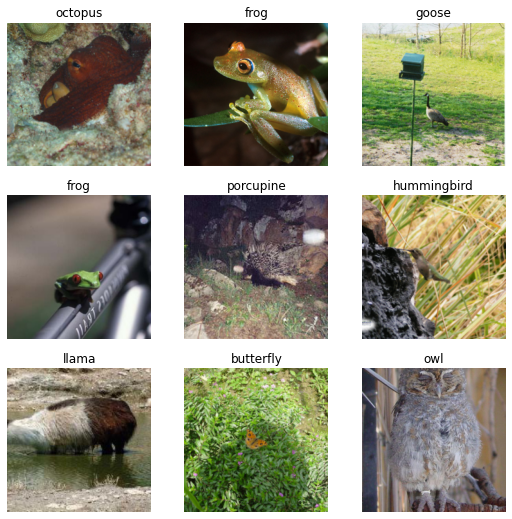

In [ ]:
animal_check = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=lambda x: parent_label(x),
    item_tfms=Resize(224))

dls = animal_check.dataloaders(path)
dls.show_batch()

In [ ]:
net_seq = nn.Sequential(
    nn.Conv2d(3, 5, 6),
    nn.MaxPool2d(3, 3),
    nn.Conv2d(5, 6, 3),
    nn.MaxPool2d(2, 2),
    nn.MaxPool2d(3, 3),
    nn.Flatten(),
    nn.Linear(726, 224),
    nn.ReLU(),
    nn.Linear(224, 26)
) # managed to get 27.6% accuracy, still not great though


net_alex = alexnet() # untrained alexnet: runs, but very poorly? best accuracy was around 15%
print(net_alex)

from torchvision.models.vgg import vgg16
net_vgg = vgg16()  # untrained vgg: thinks everything is horse? cant seem to beat 10% accuracy
print(net_vgg)

import torch.nn as nn
import torch.nn.functional as F

# currently unused
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) 
        self.pool = nn.MaxPool2d( 2, 2)
        self.fc1 = nn.Linear(6 *30 *30, 64)
        self.fc2 = nn.Linear(64, 26)

    def forward(self, x, **kwargs):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 6 * 30 * 30)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x


net = Net()


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
#learn = cnn_learner(dls, alexnet, metrics=error_rate) #transfer learning
learn = cnn_learner(dls, vgg16_bn, metrics=error_rate) #transfer learning
#learn = Learner(dls, net_seq, metrics=error_rate)  #from scratch
#learn = Learner(dls, net_alex, metrics=error_rate) #from scratch
#learn = Learner(dls, net_vgg, metrics=error_rate)  #from scratch


#learn.fit(5, 0.001,cbs=[ShowGraphCallback()])
#learn.fit(5, 0.0001,cbs=[ShowGraphCallback()])
learn.fine_tune(5)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

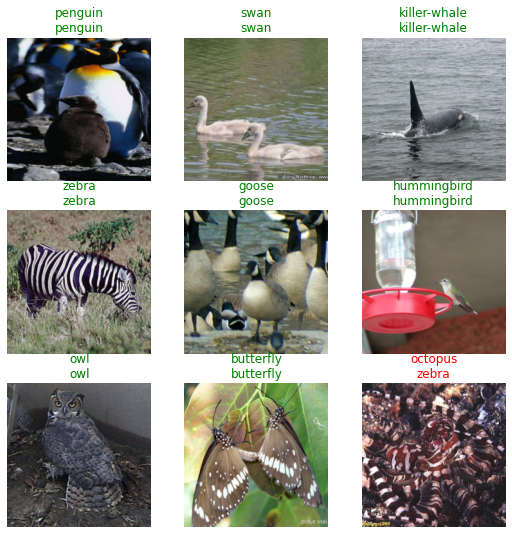

In [ ]:
learn.show_results()

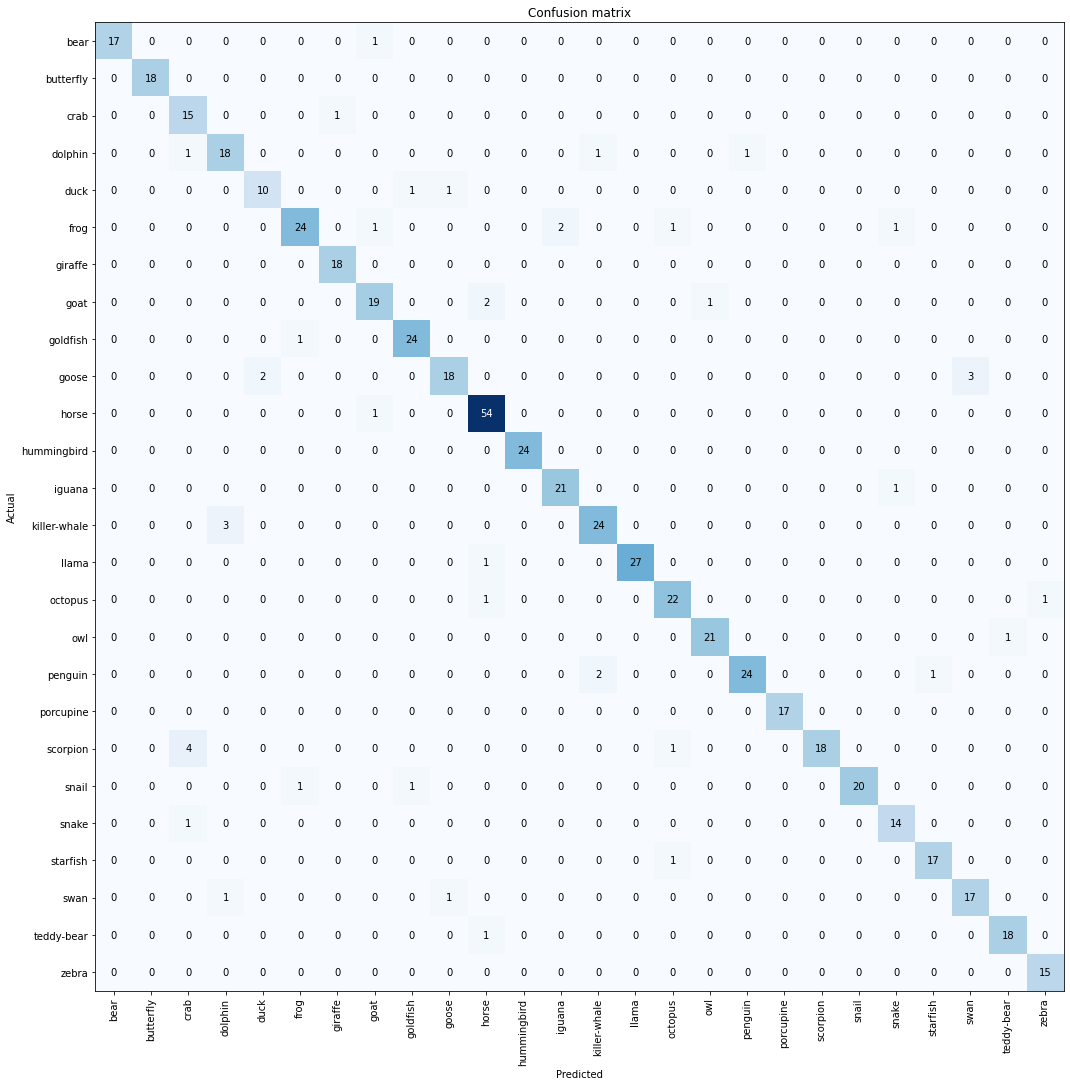

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(15, 15))

In [ ]:
correct_count = 0
num_ex = len(learn.dls.valid_ds)

for valid_ex in learn.dls.valid_ds:
  gt = valid_ex[1]
  label, label_idx, probs = learn.predict(valid_ex[0]) # get_preds for batches
  correct_count+=(gt.item() == label_idx)

print(correct_count.item())
print(f'accuracy:{correct_count.item()/num_ex}')

534
accuracy:0.9222797927461139


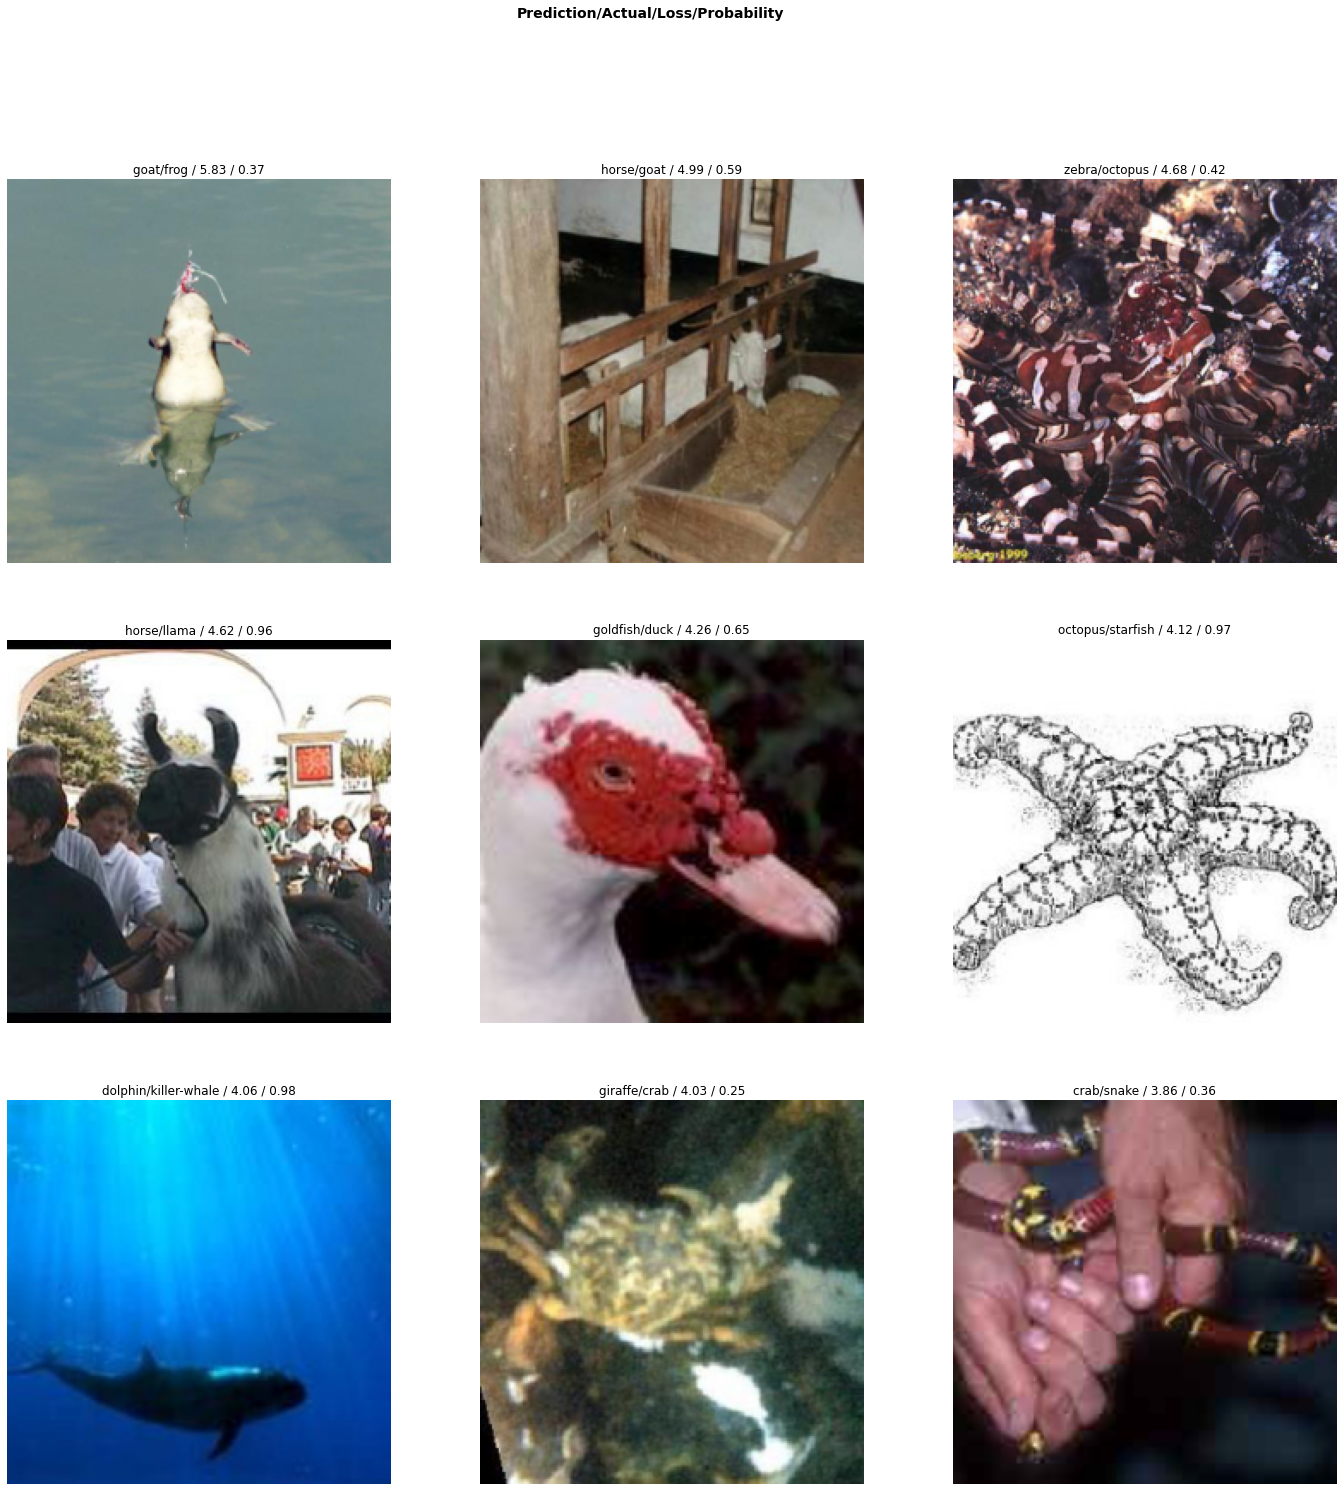

In [ ]:
interp.plot_top_losses(k = 16, figsize=(24,24))

from scratch alexnet had 15% accuracy, seemed underfitted and like it wasnt learning well. 

while transfer learning alexnet had around 70% accuracy

from scratch vgg had 10% accuracy and said almost everything is a horse.

while transfer learning vgg gave an accuracy around 92%, exceeding everything else

the custom net thats currently labeled net_seq had 27% accuracy and preformed the best overall network from scratch but still not accurate enough to be consistent

In [ ]:
testDataPath = 'content/MyDrive/csc451testData/'
testFiles = get_image_files(testDataPath)  # all img paths in this var


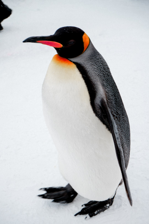

In [ ]:
imgPath = testFiles[0]
img = PILImage.create(imgPath)
label = str(imgPath).split('/')[3]
label = label.split('Test')[0]
img.to_thumb(224)

In [ ]:
animalTest,_,probs = learn.predict(img)
print(f"What animal is this? {animalTest}")
print(f"Probability for That choice: {max(probs):.6f}")
print(f"The correct choice was: {label}")

What animal is this? penguin
Probability for That choice: 0.999991
The correct choice was: penguin


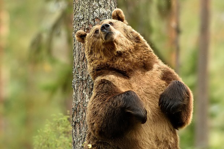

In [ ]:
imgPath = testFiles[1]
img = PILImage.create(imgPath)
label = str(imgPath).split('/')[3]
label = label.split('Test')[0]
img.to_thumb(224)

In [ ]:
animalTest,_,probs = learn.predict(img)
print(f"What animal is this? {animalTest}")
print(f"Probability for That choice: {max(probs):.6f}")
print(f"The correct choice was: {label}")

What animal is this? bear
Probability for That choice: 0.999707
The correct choice was: bear


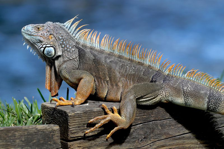

In [ ]:
imgPath = testFiles[2]
img = PILImage.create(imgPath)
label = str(imgPath).split('/')[3]
label = label.split('Test')[0]
img.to_thumb(224)

In [ ]:
animalTest,_,probs = learn.predict(img)
print(f"What animal is this? {animalTest}")
print(f"Probability for That choice: {max(probs):.6f}")
print(f"The correct choice was: {label}")

What animal is this? iguana
Probability for That choice: 1.000000
The correct choice was: iguana


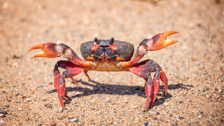

In [ ]:
imgPath = testFiles[3]
img = PILImage.create(imgPath)
label = str(imgPath).split('/')[3]
label = label.split('Test')[0]
img.to_thumb(224)

In [ ]:
animalTest,_,probs = learn.predict(img)
print(f"What animal is this? {animalTest}")
print(f"Probability for That choice: {max(probs):.6f}")
print(f"The correct choice was: {label}")

What animal is this? crab
Probability for That choice: 0.999951
The correct choice was: crab


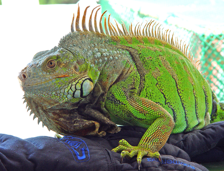

In [ ]:
imgPath = testFiles[4]
img = PILImage.create(imgPath)
label = str(imgPath).split('/')[3]
label = label.split('Test')[0]
img.to_thumb(224)

In [ ]:
animalTest,_,probs = learn.predict(img)
print(f"What animal is this? {animalTest}")
print(f"Probability for That choice: {max(probs):.6f}")
print(f"The correct choice was: {label}")

What animal is this? iguana
Probability for That choice: 1.000000
The correct choice was: iguana


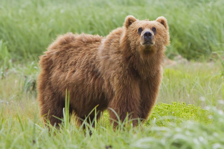

In [ ]:
imgPath = testFiles[5]
img = PILImage.create(imgPath)
label = str(imgPath).split('/')[3]
label = label.split('Test')[0]
img.to_thumb(224)

In [ ]:
animalTest,_,probs = learn.predict(img)
print(f"What animal is this? {animalTest}")
print(f"Probability for That choice: {max(probs):.6f}")
print(f"The correct choice was: {label}")

What animal is this? bear
Probability for That choice: 0.999992
The correct choice was: bear


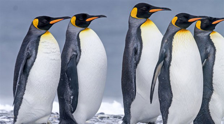

In [ ]:
imgPath = testFiles[6]
img = PILImage.create(imgPath)
label = str(imgPath).split('/')[3]
label = label.split('Test')[0]
img.to_thumb(224)

In [ ]:
animalTest,_,probs = learn.predict(img)
print(f"What animal is this? {animalTest}")
print(f"Probability for That choice: {max(probs):.6f}")
print(f"The correct choice was: {label}")

What animal is this? penguin
Probability for That choice: 1.000000
The correct choice was: penguin


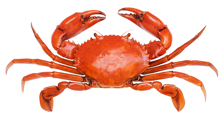

In [ ]:
imgPath = testFiles[7]
img = PILImage.create(imgPath)
label = str(imgPath).split('/')[3]
label = label.split('Test')[0]
img.to_thumb(224)

In [ ]:
animalTest,_,probs = learn.predict(img)
print(f"What animal is this? {animalTest}")
print(f"Probability for That choice: {max(probs):.6f}")
print(f"The correct choice was: {label}")

What animal is this? crab
Probability for That choice: 0.999664
The correct choice was: crab


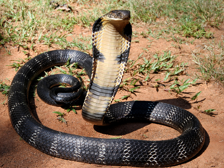

In [ ]:
imgPath = testFiles[8]
img = PILImage.create(imgPath)
label = str(imgPath).split('/')[3]
label = label.split('Test')[0]
img.to_thumb(224)

In [ ]:
animalTest,_,probs = learn.predict(img)
print(f"What animal is this? {animalTest}")
print(f"Probability for That choice: {max(probs):.6f}")
print(f"The correct choice was: {label}")

What animal is this? snake
Probability for That choice: 0.999359
The correct choice was: snake


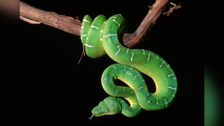

In [ ]:
imgPath = testFiles[9]
img = PILImage.create(imgPath)
label = str(imgPath).split('/')[3]
label = label.split('Test')[0]
img.to_thumb(224)

In [ ]:
animalTest,_,probs = learn.predict(img)
print(f"What animal is this? {animalTest}")
print(f"Probability for That choice: {max(probs):.6f}")
print(f"The correct choice was: {label}")

What animal is this? snake
Probability for That choice: 0.959557
The correct choice was: snake
